## 

# Frequentist와 Bayesian 방법론을 활용한 A/B 테스트에서 전환율 평가

## 실험 개요
이번 A/B 테스트는 새로운 웹페이지 디자인이 기존 디자인보다 구매 전환율을 개선할 수 있는지 평가하기 위해 설계되었습니다. 이를 위해 사용자를 Control 그룹(기존 웹페이지)과 Treatment 그룹(새 웹페이지)으로 나누고, 두 그룹 간의 전환율 차이를 분석하였습니다. 분석에는 Frequentist와 Bayesian 접근법을 모두 사용하여 두 방법론의 차이를 비교하고, 실험 결과에 대한 통계적 결론을 도출하였습니다.

Frequentist 방법에서는 카이제곱 검정을 통해 두 그룹 간 전환 여부의 빈도의 차이를 분석했습니다. 그러나 이 방법은 전환율의 크기나 확률적인 해석에 한계가 있었습니다. 이를 보완하기 위해 Bayesian 접근법 사용하여 분석을 진행했습니다. Bayesian 접근법에서는 먼저 부트스트래핑(bootstrapping)을 통해 사전 분포(prior)를 설정하고, 베타-베르눌리 conjugate 관계를 활용하여 사후 분포(posterior)를 추정했습니다. 또한, 교육적 목적으로 MCMC(Markov Chain Monte Carlo) 샘플링을 추가적으로 적용하여, 사후 분포 추정했습니다.

최종적으로, 전환율 차이에 대한 불확실성을 정량화하고, Treatment 그룹이 Control 그룹보다 전환율을 개선할 가능성이 낮다는 결론을 도출하였습니다.

## 분석 방법론

### 실험 설계

새 웹페이지의 구매 전환 효과를 평가하기 위해 기존 웹페이지와 비교하는 분석을 계획했습니다. 각 그룹은 다음과 같이 나뉩니다:
- Control Group: 기존 웹페이지('old_page')에 노출된 그룹
- Treatment Group: 새로운 웹페이지('new_page')에 노출된 그룹

### 측정 지표 및 정의

**Frequentist A/B Test**:

본 테스트의 주요 측정 지표는 **전환 여부의 빈도**입니다. 전환 여부는 각 그룹 내에서 구매를 완료한 사용자 수와 완료하지 않은 사용자 수를 기준으로 카이제곱 검정을 통해 두 그룹 간의 차이를 분석합니다. 전환 여부의 빈도는 다음과 같이 정의됩니다:

$$
\text{전환 여부의 빈도} = 
\begin{cases} 
n_{\text{converted}} & \text{(전환된 사용자 수)} \\
n_{\text{not_converted}} & \text{(전환되지 않은 사용자 수)} 
\end{cases}
$$


**Bayesian A/B Test** :

본 테스트의 주요 측정 지표는 **구매 전환율**입니다. 이는 노출된 사용자 중 구매를 완료한 비율로 정의되며, 다음과 같이 계산됩니다:

$$
\text{구매 전환율 (%)} = \frac{\text{구매 완료 사용자 수}}{\text{노출된 사용자 수}}
$$



## 분석 방법론 선택 이유
### Frequentist Approach의 한계
빈도주의 접근법은 가설 검증을 통해 통계적 유의성을 판단합니다. 그러나 이 방법은 p-value에 과도하게 의존하며, 실제 효과 크기나 데이터 내 존재하는 불확실성에 대한 정보를 제공하지 않습니다. 또한, 사전 정보나 외부 지식을 통합하기 어렵고, 결과 해석이 이진적(유의하다/유의하지 않다)이라는 점에서 한계를 가집니다.

### Bayesian Approach의 필요성
베이지안 접근법은 사전 분포를 설정하여 사후 분포를 통해 결과를 업데이트하고 해석합니다. 이 방법은 결과에 대한 확률적 해석을 제공하여, 전환율의 차이가 얼마나 '확률적으로' 의미 있는지를 설명할 수 있습니다. 또한, 작은 표본에서도 유용하며, 사전 지식이나 다른 출처의 정보를 통합할 수 있습니다.

## 분석 목표
본 프로잭트의 목표는 두 가지 통계적 방법론을 적용하여, 각각의 장단점을 비교 분석하고 해당 데이터 세트에 대한 페이지 효과성 평가에 가장 적합한 접근법을 찾는 것입니다. 이를 통해 실질적인 인사이트를 도출하고, 실험 결과를 바탕으로 비즈니스 결정에 도움을 줄 수 있는 actionable insight를 제시하는 것이 목표입니다.

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.multitest import multipletests
from scipy.stats import beta
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import pymc as pm
import arviz as az

## 데이터셋 개요

### 출처: [Kaggle](https://www.kaggle.com/saraabdelaal/abtestdata)

In [18]:
# 데이터 불러오기
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### 데이터셋 구성
- **user_id**: 사용자의 고유 식별자입니다.
- **timestamp**: 사용자가 페이지를 방문한 시간입니다.
- **group**: 사용자가 속한 그룹을 나타냅니다. 값은 'control' 또는 'treatment' 입니다.
- **landing_page**: 사용자가 방문한 랜딩 페이지를 나타냅니다. 값은 'old_page' 또는 'new_page' 입니다.
- **converted**: 사용자의 전환 여부를 나타냅니다. 0은 전환되지 않음, 1은 전환됨을 의미합니다.

## 데이터 전처리 및 탐색

In [19]:
# 결측치 확인
missing_values = df.isnull().sum()
print("결측치:\n", missing_values)

결측치:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


출력된 결과에서 모든 열의 결측값 수가 0으로 나타나, 이 데이터셋에는 결측값이 없음을 확인할 수 있습니다.

In [20]:
# 중복된 사용자 ID 확인
duplicate_users = df[df.duplicated(['user_id'], keep=False)]
print("중복된 사용자 ID:\n", duplicate_users)

중복된 사용자 ID:
         user_id                   timestamp      group landing_page  converted
22       767017  2017-01-12 22:58:14.991443    control     new_page          0
192      656468  2017-01-18 07:13:29.805052  treatment     new_page          1
226      773693  2017-01-23 18:05:45.167335    control     old_page          1
240      733976  2017-01-11 15:11:16.407599    control     new_page          0
246      704650  2017-01-04 19:10:52.655062  treatment     new_page          0
...         ...                         ...        ...          ...        ...
294308   905197  2017-01-03 06:56:47.488231  treatment     new_page          0
294309   787083  2017-01-17 00:15:20.950723    control     old_page          0
294328   641570  2017-01-09 21:59:27.695711    control     old_page          0
294331   689637  2017-01-13 11:34:28.339532    control     new_page          0
294355   744456  2017-01-13 09:32:07.106794  treatment     new_page          0

[7788 rows x 5 columns]


총 7788개의 중복된 사용자 ID가 발견되었으며, 이는 동일한 사용자가 여러 번 데이터에 포함되어 있음을 나타냅니다. 다음은 각 중복 사용자의 발생 빈도를 분석하여 자세히 살펴보겠습니다.

In [21]:
# 각 사용자 ID가 몇 번 중복되었는지 확인
duplicate_counts = df[df.duplicated(['user_id'], keep=False)].groupby('user_id').size()

# 두 번 이상 중복된 사용자 ID 출력
print("중복된 사용자 ID의 중복 횟수:")
print(duplicate_counts)

# 특정 사용자 ID에 대한 자세한 정보 출력
example_user_id = duplicate_counts.index[0]
example_user_data = df[df['user_id'] == example_user_id]
print(f"\n사용자 ID {example_user_id}의 세부 정보:")
print(example_user_data)


중복된 사용자 ID의 중복 횟수:
user_id
630052    2
630126    2
630137    2
630320    2
630471    2
         ..
945627    2
945645    2
945703    2
945797    2
945971    2
Length: 3894, dtype: int64

사용자 ID 630052의 세부 정보:
        user_id                   timestamp      group landing_page  converted
213114   630052  2017-01-07 12:25:54.089486  treatment     old_page          1
230259   630052  2017-01-17 01:16:05.208766  treatment     new_page          0


데이터셋에서 각 사용자의 중복 빈도를 조사한 결과, 3894개의 중복 사용자가 정확히 두 번씩 기록되어 총 7788개의 중복 항목이 있는걸 확인할 수 있습니다. 사용자 ID 630052의 경우, Treatment 그룹에 속해 있음에도 불구하고 'old_page' 랜딩 페이지에 노출된 사례가 확인되었습니다. 이는 사용자가 여러 번 사이트에 접속하여 두 가지 랜딩 페이지에 모두 노출된 것으로 추정됩니다. 특정 그룹에 부합하지 않는 랜딩 페이지에 노출된 데이터만을 선택적으로 제거할 수는 있지만, 이러한 데이터가 전체 데이터셋에서 차지하는 비율이 낮고 데이터의 일관성을 해칠 위험이 있습니다. 따라서 중복 사용자 데이터를 전체적으로 제거하는 결정을 하였습니다.

In [22]:
# 이러한 사용자를 데이터에서 제거
df = df[~df['user_id'].isin(duplicate_counts)]

print("제거 후 데이터:")
print(df)


제거 후 데이터:
        user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[294478 rows x 5 columns]


## 데이터 변환

이 데이터는 약 22일 동안 수집되었으며, 실제 비즈니스 환경에서는 이 기간 동안 실험의 진행 상황을 지속적으로 모니터링합니다. 이를 위해 'week' 칼럼을 추가하여 각 주차별 데이터 상태를 파악할 수 있도록 했으며, 이 칼럼은 베이지안 접근법에서 사전 분포(prior distribution)를 설정하는 중요한 기초 데이터로 활용됩니다.

In [23]:
# 타임스탬프 컬럼을 datetime 형식으로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 날짜 부분만 추출하여 새로운 컬럼 생성
df['date'] = df['timestamp'].dt.date

# 실험 시작 날짜를 datetime 객체로 변환
experiment_start = pd.to_datetime(df['date'].min())

# 실험 시작 날짜에 따른 주 번호 계산
df['week'] = ((df['timestamp'] - experiment_start) / pd.to_timedelta(7, unit='d')).astype(int) + 1
df

,user_id,timestamp,group,landing_page,converted,date,week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21,3
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,2017-01-03,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,2017-01-12,2
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,2017-01-22,3
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,2017-01-15,2


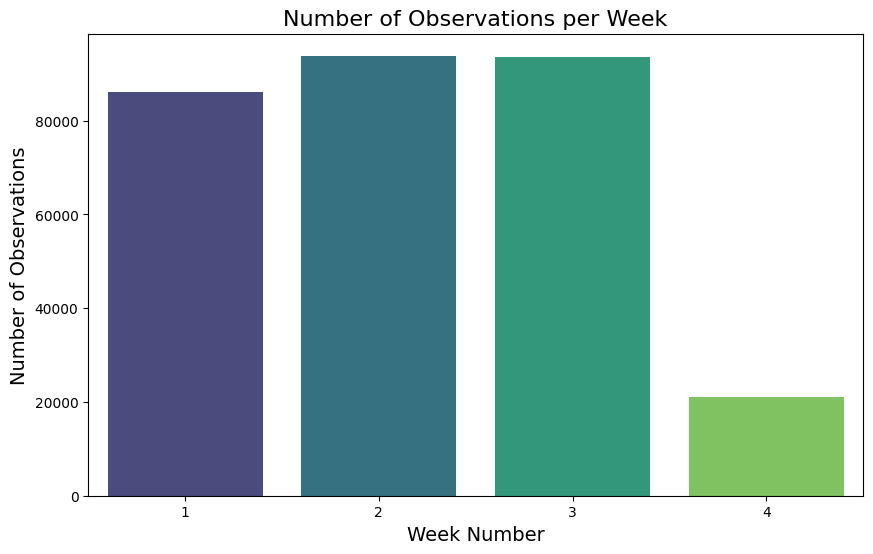

In [24]:
# 'week' 컬럼의 값 개수 계산
week_counts = df['week'].value_counts().sort_index()

# 주별 관찰 수를 바 차트로 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=week_counts.index, y=week_counts.values, palette='viridis')

# 차트 제목 및 레이블 설정
plt.title('Number of Observations per Week', fontsize=16)
plt.xlabel('Week Number', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)
plt.show()


22일간 데이터가 수집되었기 때문에, 4주차에 관찰된 데이터 수가 상대적으로 적습니다. 이러한 데이터 불균형이 전체 실험 결과에 미칠 영향을 평가하기 위해, 효과 크기(effect size)와 필요한 최소 샘플 크기를 계산하여 분석해보겠습니다.

## 효과 크기(effect size) 와 검정력 분석 (power analysis)를 통한 필요한 샘플 크기 계산

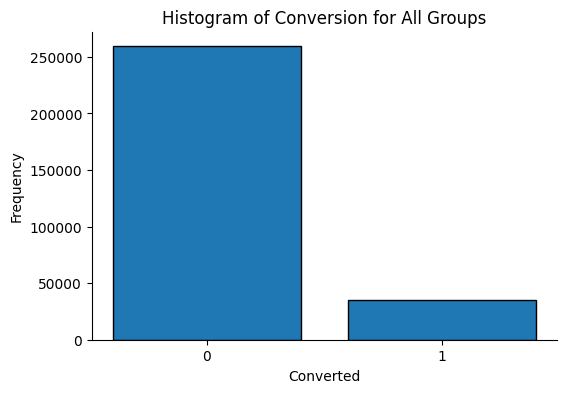

전환율 평균 (CVR MEAN): 0.1197, 표준 편차 (STD): 0.3246
Effect Size: 0.0627
그룹별 필요한 샘플 크기: 3997
실제 데이터 크기 (Control): 147202, (Treatment): 147276


In [25]:
# 전환율 히스토그램
plt.figure(figsize=(6, 4))
plt.hist(df['converted'], bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Converted')
plt.ylabel('Frequency')
plt.title('Histogram of Conversion for All Groups')
plt.xticks([0, 1])
plt.show()

# 전환율의 평균 및 표준 편차 계산
cvr_mean = df['converted'].mean()
cvr_std = df['converted'].std()

print(f"전환율 평균 (CVR MEAN): {cvr_mean:.4f}, 표준 편차 (STD): {cvr_std:.4f}")

# 실험 그룹의 목표 전환율 설정
desired_cvr_v1 = 0.14

# 효과 크기 계산
effect_size = (desired_cvr_v1 - cvr_mean) / cvr_std
print(f"Effect Size: {effect_size:.4f}")


# 두 그룹 간의 샘플 크기 비율 계산
sizes = [len(df[df['group'] == 'control']), len(df[df['group'] == 'treatment'])]
ratio = max(sizes) / min(sizes)

# 전력 분석 초기화 및 필요한 샘플 크기 계산
analysis = TTestIndPower()
required_sample_size = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, nobs1=None, ratio=ratio)

# 결과 출력
print(f"그룹별 필요한 샘플 크기: {int(np.ceil(required_sample_size))}")
print(f"실제 데이터 크기 (Control): {sizes[0]}, (Treatment): {sizes[1]}")



- 전체 전환율은 약 11.97%로, 전체 사용자 중 약 12%가 전환되었습니다.

- 전환율의 변동성이 0.3246으로, 사용자 간 전환율의 차이가 상대적으로 큽니다.
  
- 각 그룹에서 최소 3997명의 샘플이 필요합니다. 이 정도의 샘플이 있어야 두 그룹 간 차이를 유의미하게 검정할 수 있습니다.

- 두 그룹 간의 효과 크기는 0.0627로 작습니다. 하지만 필요한 샘플 크기(3997)에 비해 실제 데이터 크기가 매우 크므로, 효과를 식별할 충분한 통계적 파워가 있습니다.

- 두 그룹 모두 14만 명 이상의 데이터를 포함하고 있어, 최소 샘플 크기보다 훨씬 많은 데이터를 확보한 상태입니다.

##### 4주차 데이터량

- 4주차 데이터는 약 2만 건으로, 각 그룹별 최소 샘플 크기인 3997명을 크게 초과합니다. 따라서 4주차의 데이터량이 부족하지 않습니다.

- 최소 샘플 크기를 충족하므로, 4주차 데이터로도 통계적으로 유의미한 결과를 도출할 수 있습니다.

- 4주차 데이터량이 적더라도, 전체 데이터를 통해 통계적 검정력이 유지되므로 실험 결과에 큰 영향을 미치지 않습니다.

- 따라서, 4주차의 상대적으로 적은 데이터량은 문제가 되지 않습니다.


## A/B Test: Frequntist Approach

먼저 Control 그룹과 Treatment 그룹의 평균 전환율을 비교해보겠습니다.

In [26]:
# 분석할 주 수 설정
NUM_WEEKS = 4 # NUM_WEEKS 값을 조정하여 각 주차별로 실험 진행 상황을 모니터링할 수 있음

# 특정 주 수에 해당하는 데이터 필터링
experiment_data = df[df['week'] <= NUM_WEEKS]

# 그룹 분리
control = experiment_data[experiment_data['group'] == 'control']
treatment = experiment_data[experiment_data['group'] == 'treatment']

# 그룹 별 전환율 계산
control_conversion_rate = control['converted'].mean() * 100
treatment_conversion_rate = treatment['converted'].mean() * 100

# 전환율 차이 (Lift) 계산
lift = treatment_conversion_rate - control_conversion_rate

# 결과 출력
print(f"Control 그룹 전환율: {control_conversion_rate:.3f}%")
print(f"Treatment 그룹 전환율: {treatment_conversion_rate:.3f}%")
print(f"전환율 차이 (Lift): {lift:.3f}%")


Control 그룹 전환율: 12.040%
Treatment 그룹 전환율: 11.892%
전환율 차이 (Lift): -0.148%


먼저 Control 그룹과 Treatment 그룹의 평균 전환율을 살펴본 결과, Control 그룹의 전환율은 12.040%, Treatment 그룹의 전환율은 11.892%로 나타났습니다. 두 그룹 간의 전환율 차이는 -0.148%로, Treatment 그룹의 전환율이 Control 그룹보다 약간 낮은 수치를 보이고 있습니다.

이 차이가 통계적으로 유의미한지를 판단하기 위해서는 추가적인 통계적 검정이 필요합니다. 통계적 검정을 통해 두 그룹 간의 차이가 단순한 우연인지, 아니면 실제로 유의미한 차이가 있는지를 검증하겠습니다. 현재 결과만으로는 전환율 차이가 작고 음수이기 때문에, Treatment 그룹의 개선 효과는 매우 작거나 없을 가능성이 높다고 판단됩니다.

### Chi-square 검정

Frequentist A/B Testing에서는 **Chi-square test**를 사용할 예정입니다. 그 이유는 다음과 같습니다:

- 위에서 전환율의 평균과 표준 편차를 계산한 결과, 전환율의 편차가 매우 크다는 점을 확인했습니다. 이 경우, 연속형 데이터인 전환율을 기반으로 한 t-test는 그룹 간의 차이를 실제보다 과장하거나 왜곡할 가능성이 있습니다.

- Chi-square test는 전환 여부(0 또는 1)와 같은 범주형 데이터를 비교하는 데 적합하며, 편차가 큰 상황에서도 더 안정적이고 일관된 결과를 제공합니다.

따라서, 주어진 데이터의 특성을 고려할 때 Chi-square test가 더 적합한 방법이라고 판단됩니다.


$$
H_0: \text{Control 그룹과 Treatment 그룹의 전환 여부의 빈도 차이가 동일하다.}
$$

$$
H_1: \text{Control 그룹과 Treatment 그룹의 전환 여부의 빈도 차이가 다르다.}
$$


In [27]:
# 혼동 행렬 (confusion matrix)
cvr_data = [
    len(df[(df['group'] == 'control') & (df['converted'] == 1)]),  # control 그룹, 전환된 수
    len(df[df['group'] == 'control']),   # control 그룹 전체 수
    len(df[(df['group'] == 'treatment') & (df['converted'] == 1)]),  # treatment 그룹, 전환된 수
    len(df[df['group'] == 'treatment'])  # treatment 그룹 전체 수
]

# 전환된 수
conv = [cvr_data[0], cvr_data[2]]

# 전환되지 않은 수
no_conv = [cvr_data[1] - cvr_data[0], cvr_data[3] - cvr_data[2]]

# 카이제곱 검정 수행
chi2, p_val, d_f, expected = chi2_contingency([conv, no_conv])

# 결과 출력
print("카이제곱 통계량:", format(chi2, '.3f'))
print("p_value:", p_val)


카이제곱 통계량: 1.516
p_value: 0.2182316121631168


검정 결과에 따르면, 21.82%의 확률로 카이제곱 통계량 1.516보다 더 극단적인 값이 우연에 의해 발생할 수 있음을 의미합니다. P-value가 유의수준 0.05보다 훨씬 크기 때문에, 두 그룹 간 전환 여부의 빈도 차이는 통계적으로 유의미하지 않다고 결론지을 수 있습니다.

하지만, 전체 데이터를 기반으로 한 분석만으로는 실험 기간 중 특정 시점에서의 변화를 놓칠 수 있습니다. 따라서, 특정 날짜별로 전환율의 차이를 좀 더 세부적으로 분석하기 위해 **일별 Chi-square 검정**를 수행해 보겠습니다. 이를 통해 각 날짜마다 그룹 간 전환율 차이가 발생했는지 확인하고, 일자별로 유의미한 변화가 있는지 평가해 보겠습니다.

### 일별 Chi-square 검정

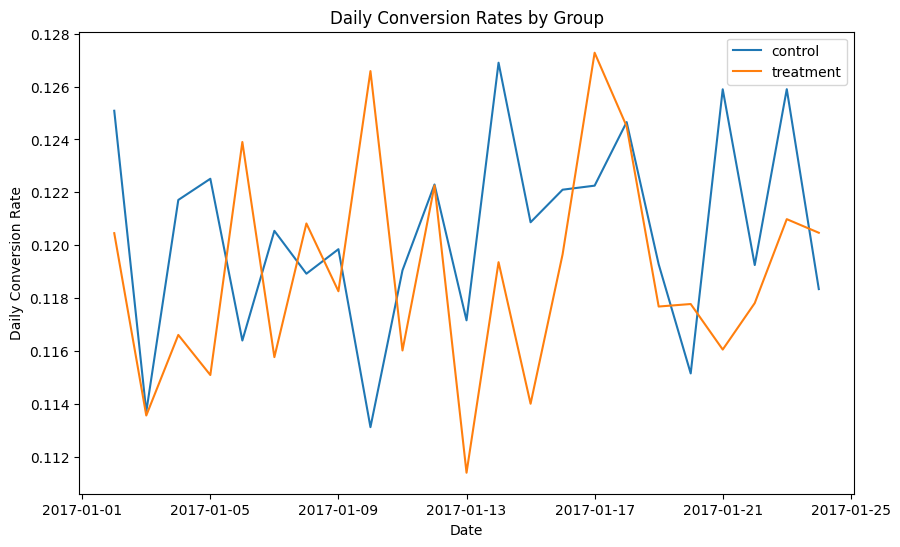

In [28]:
# 그룹별 일일 전환율 계산
daily_conversion = df.groupby(['date', 'group'])['converted'].mean().reset_index()

# 그룹별 일일 전환율 시각화
plt.figure(figsize=(10, 6))
for group in ['control', 'treatment']:
    plt.plot(daily_conversion[daily_conversion['group'] == group]['date'],
             daily_conversion[daily_conversion['group'] == group]['converted'],
             label=group)

plt.xlabel('Date')
plt.ylabel('Daily Conversion Rate')
plt.title('Daily Conversion Rates by Group')
plt.legend()
plt.show()


이 그래프는 Control 그룹과 Treatment 그룹의 일일 전환율 변화를 보여줍니다. 두 그룹 모두 전환율의 변동이 크며, 시각적으로는 어느 한쪽이 명확하게 우위를 점한다고 보기는 어렵습니다. 특히, 날짜별로 두 그룹의 전환율이 교차하거나 유사한 추세를 보이는 경우가 많아, 두 그룹 간에 일관된 전환율 차이가 없는 것처럼 보입니다.

하지만, 시각적 분석만으로는 이러한 변동이 통계적으로 유의미한 차이를 나타내는지 판단하기 어렵기 때문에 일별 Chi-square 테스트를 통해 각 날짜마다 두 그룹 간 전환 여부의 차이가 통계적으로 유의미한지를 확인해보겠습니다.

약 1개월간의 데이터를 대상으로 일별 Chi-square 테스트를 수행할 경우, 다중 검정으로 인해 **1종 오류(Type I Error)** 가 증가할 가능성이 있습니다. 이를 방지하기 위해, **Bonferroni 보정**을 사용하여 유의수준(알파 값)을 조정하고, 다중 검정에 따른 1종 오류를 줄이도록 하겠습니다. 



For each day \( i \):

$$
H_0: \text{해당 날짜에 Control 그룹과 Treatment 그룹의 전환 여부의 빈도 차이가 동일하다.}
$$

$$
H_1: \text{해당 날짜에 Control 그룹과 Treatment 그룹의 전환 여부의 빈도 차이가 다르다.}
$$


In [29]:
# 일별 카이제곱 검정 수행
unique_dates = df['date'].unique()  # 날짜별 데이터 추출
p_values_per_day = []  # 각 날짜의 p-value 저장 리스트

for current_date in unique_dates:
    filtered_data = df[df['date'] == current_date]  # 특정 날짜의 데이터 필터링
    conversion_data = [
        len(filtered_data[(filtered_data['group'] == 'control') & (filtered_data['converted'] == 1)]),  # control 그룹 전환된 수
        len(filtered_data[filtered_data['group'] == 'control']),  # control 그룹 전체 수
        len(filtered_data[(filtered_data['group'] == 'treatment') & (filtered_data['converted'] == 1)]),  # treatment 그룹 전환된 수
        len(filtered_data[filtered_data['group'] == 'treatment'])  # treatment 그룹 전체 수
    ]
    
    converted = [conversion_data[0], conversion_data[2]]  # 전환된 수: [control, treatment]
    not_converted = [conversion_data[1] - conversion_data[0], conversion_data[3] - conversion_data[2]]  # 전환되지 않은 수: [control, treatment]
    
    chi2_stat, p_value, degrees_freedom, expected_values = chi2_contingency([converted, not_converted])  # 카이제곱 검정 수행
    p_values_per_day.append(p_value)  # p-value 저장

# Bonferroni correction을 사용한 다중 검정
alpha = 0.05
reject_null_hypothesis, bonferroni_corrected_p_values, _, _ = multipletests(p_values_per_day, alpha=alpha, method='bonferroni')

# 결과를 DataFrame에 저장
results = pd.DataFrame({
    '날짜': unique_dates,
    'P-value': p_values_per_day,
    '보정된 P-value (Bonferroni)': bonferroni_corrected_p_values,
    '귀무가설 기각 여부': reject_null_hypothesis
})

# 날짜별로 정렬하여 결과 출력
results.sort_values(by='날짜').reset_index(drop=True)


,날짜,P-value,보정된 P-value (Bonferroni),귀무가설 기각 여부
0,2017-01-02,0.619677,1.000000,False
1,2017-01-03,1.000000,1.000000,False
2,2017-01-04,0.378257,1.000000,False
3,2017-01-05,0.198097,1.000000,False
4,2017-01-06,0.188196,1.000000,False
5,2017-01-07,0.407107,1.000000,False
6,2017-01-08,0.753426,1.000000,False
7,2017-01-09,0.796321,1.000000,False
8,2017-01-10,0.017129,0.393969,False
9,2017-01-11,0.602411,1.000000,False


2017-01-10을 제외한 모든 날짜의 P-value는 0.05보다 컸으며, Bonferroni 보정을 적용한 후에는 모든 날짜에서 유의수준 0.05를 초과하는 값이 나왔습니다. 2017-01-10의 경우 P-value가 0.017129로 유의수준보다 작았지만, 보정 후에는 0.05를 초과하게 되었습니다. 따라서, 모든 날짜에 대해 두 그룹 간 전환율 차이가 통계적으로 유의미하지 않다는 결론을 내릴 수 있습니다. 즉, 실험 기간 동안 특정 날짜에 따라 전환율에 유의한 차이가 발생했다고 보기는 어렵습니다.

## A/B Test: Bayesian Approach

이번 베이지안 A/B 테스트에서는 부트스트래핑을 통해 컨트롤 그룹의 첫번째 주차의 데이터로 부터 사전 분포(prior)를 생성한 후, 두 가지 방법으로 사후 분포(posterior)를 업데이트하고 비교하는 접근 방식을 사용했습니다. 두 방법 모두 베타 분포와 베르누이 분포의 conjugate prior 관계를 활용했습니다.

1. 베타-베르누이 업데이트 방식

첫 번째 방법은 베타 분포와 베르누이 분포의 conjugate 관계를 활용해 각 주차 데이터를 기반으로 사후 분포를 순차적으로 업데이트하는 방식입니다. 컨트롤 그룹의 첫 번째 주차 데이터를 부트스트래핑하여 전환율에 대한 사전 분포를 생성하고, 이후 매주 데이터를 반영해 사후 분포를 업데이트했습니다. 이를 통해 주차별 전환율 분포의 변화를 추적하고, 최종적으로 컨트롤 그룹과 처리 그룹 간의 사후 분포를 비교하여 리프트(lift)와 전환율 차이를 평가했습니다.

2. MCMC 기반 사후 분포 추정

두 번째 방법은 MCMC(Markov Chain Monte Carlo) 기법을 사용해 사후 분포를 추정하는 방식입니다. 첫 번째 주차 데이터를 바탕으로 베타 분포를 사전 분포로 사용하고, 각 주차별 데이터를 추가해 베르누이 분포의 우도(likelihood)를 정의했습니다. 이후 MCMC 샘플링을 통해 사후 분포를 추정하고, **HDI(Highest Density Interval)** 를 계산하여 두 그룹 간의 전환율 차이를 확률적으로 평가했습니다.

#### MCMC를 사용하는 이유

이번 분석에서 사용된 베타-베르누이 모델은 conjugate prior 관계에 있고 복잡한 분포가 아니기 때문에 MCMC가 반드시 필요한 상황은 아닙니다. 그럼에도 불구하고 MCMC를 사용한 이유는 다음과 같습니다:

- **모델 확장성**: 단순한 베타-베르누이 모델을 넘어서 더 복잡한 우도(likelihood function)를 가지는 모델로 확장될 경우에도 MCMC는 효과적인 도구입니다. 향후 모델이 다층 구조나 더 많은 파라미터를 포함하는 복잡한 구조로 발전할 때도 MCMC는 강력한 샘플링 도구로 활용될 수 있습니다.

- **교육적 목적**: MCMC는 복잡한 베이지안 모델을 다룰 때 자주 사용되기 때문에, 이번 실험에서 MCMC를 적용함으로써 그 과정과 결과를 학습하고 익히는 데 유용한 교육적 가치를 제공합니다.

결론적으로, MCMC는 단순한 베타-베르누이 모델에서는 필수가 아니지만, 확장성과 유연성을 제공하기 때문에 이번 실험에서도 적용하였습니다.

### 사전 분포 (Prior Distribution) 생성

#### 첫번째 주 Control 그룹 데이터 추출

In [40]:
# 첫번째 주 (Week 1) Control 그룹 데이터 추출
prior_control = df[(df['week'] == 1) & (df['group'] == 'control')] # 그전에 있었던 historical data라고 가정

#### 부트스트래핑을 통한 평균 전환율 계산

In [42]:
# 시드 설정
np.random.seed(2024)

# 부트스트랩 샘플 평균 생성
prior_control_means = []

n_iterations = 30000  # 부트스트랩 샘플 수
sample_size = 3000    # 각 부트스트랩 샘플의 크기

for i in range(n_iterations):
    # 표본 추출 후 control 그룹의 평균 전환율 계산
    sample_mean_control = prior_control.sample(sample_size, replace=True)['converted'].mean()
    prior_control_means.append(sample_mean_control)

# numpy array로 변환
prior_control_means = np.array(prior_control_means)

#### 사전 분포 추정

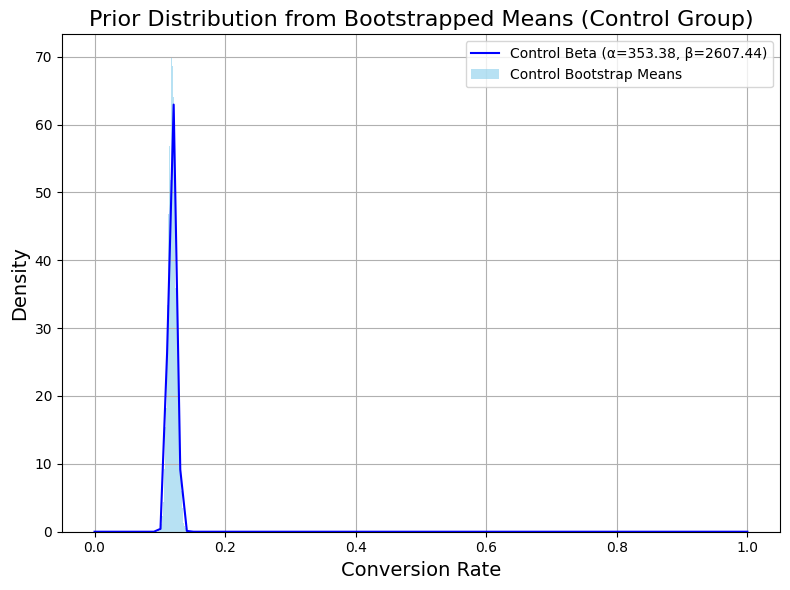

In [43]:
# 부트스트랩된 평균으로부터 베타 분포의 매개변수 추출
prior_control_alpha, prior_control_beta, _, _ = beta.fit(prior_control_means, floc=0, fscale=1)

# 베타 분포에 맞게 x축 범위 설정
x = np.linspace(0, 1, 100)

# 베타 확률 밀도 함수 계산 (Control 그룹의 prior)
y_control = beta.pdf(x, prior_control_alpha, prior_control_beta)

# 그래프 준비: Control 그룹과 Treatment 그룹 비교
fig, ax = plt.subplots(figsize=(8, 6))

# Control 그룹 prior 분포 시각화
ax.plot(x, y_control, color='blue', label=f'Control Beta (α={prior_control_alpha:.2f}, β={prior_control_beta:.2f})')
ax.hist(prior_control_means, bins=30, density=True, alpha=0.6, color='skyblue', label='Control Bootstrap Means')

# 그래프 설정
ax.set_title('Prior Distribution from Bootstrapped Means (Control Group)', fontsize=16)
ax.set_xlabel('Conversion Rate', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
ax.grid(True)

# 전체 타이틀
plt.tight_layout()
plt.show()


## 베타-베르누이 업데이트

### Control 그룹의 주별 사후 분포 (Posterior Distribution) 업데이트

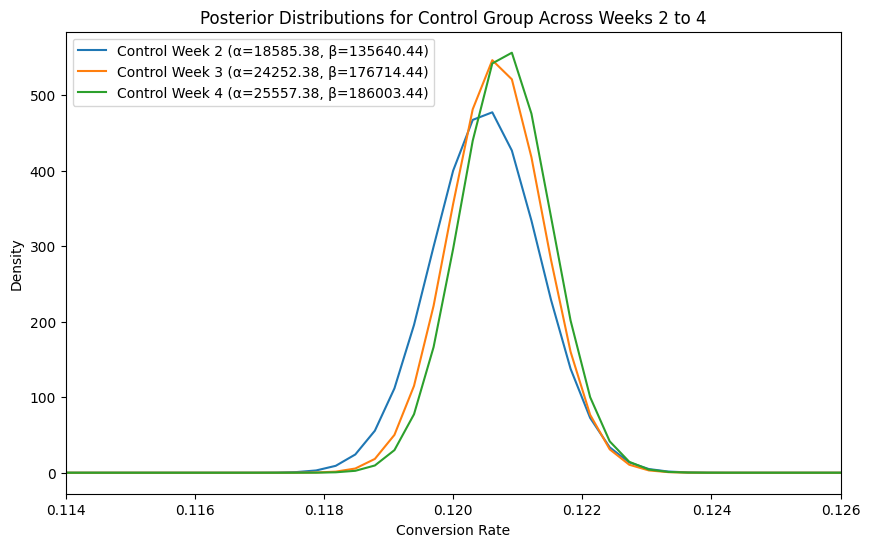

In [45]:
# prior 매개변수를 새 변수에 저장하여 업데이트 시 원본 값 보존
initial_control_alpha = prior_control_alpha
initial_control_beta = prior_control_beta

# 베타 분포에 맞게 x축 범위 설정
x = np.linspace(0.1, 0.13, 100)

# Control 그룹의 posterior를 주별로 업데이트하고 그래프에 표시 (Control 그룹)
plt.figure(figsize=(10, 6))
for week in range(2, 5):  # 2~4주
    control_data = df[(df['week'] == week) & (df['group'] == 'control')]
    control_conversions = control_data['converted'].sum()
    control_samples = control_data['converted'].count()
    
    # Control 그룹의 posterior 업데이트
    posterior_control_alpha = prior_control_alpha + control_conversions
    posterior_control_beta = prior_control_beta + (control_samples - control_conversions)
    
    # Control posterior 시각화
    y_control_posterior = beta.pdf(x, posterior_control_alpha, posterior_control_beta)
    plt.plot(x, y_control_posterior, label=f'Control Week {week} (α={posterior_control_alpha:.2f}, β={posterior_control_beta:.2f})')

    # 다음 loop을 위해 prior 업데이트
    prior_control_alpha = posterior_control_alpha
    prior_control_beta = posterior_control_beta

# 그래프 설정 및 시각화 (Control 그룹)
plt.title('Posterior Distributions for Control Group Across Weeks 2 to 4')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.xlim(0.114, 0.126)
plt.legend()
plt.show()

### Treatment 그룹의 주별 사후 분포 (Posterior Distribution) 업데이트

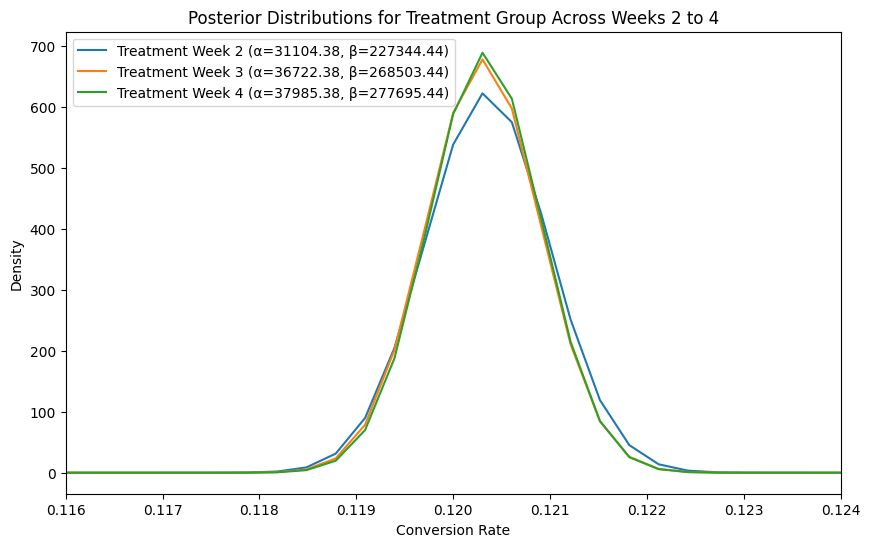

In [46]:
# prior 매개변수를 새 변수에 저장하여 업데이트 시 원본 값 보존
initial_treatment_alpha = prior_control_alpha
initial_treatment_beta = prior_control_beta

# Treatment 그룹의 posterior를 주별로 업데이트하고 그래프에 표시 (Treatment 그룹)
plt.figure(figsize=(10, 6))
for week in range(2, 5):
    treatment_data = df[(df['week'] == week) & (df['group'] == 'treatment')]
    treatment_conversions = treatment_data['converted'].sum()
    treatment_samples = treatment_data['converted'].count()
    
    # Treatment 그룹의 posterior 업데이트
    posterior_treatment_alpha = initial_treatment_alpha + treatment_conversions
    posterior_treatment_beta = initial_treatment_beta + (treatment_samples - treatment_conversions)
    
    # Treatment posterior 시각화
    y_treatment_posterior = beta.pdf(x, posterior_treatment_alpha, posterior_treatment_beta)
    plt.plot(x, y_treatment_posterior, label=f'Treatment Week {week} (α={posterior_treatment_alpha:.2f}, β={posterior_treatment_beta:.2f})')

    # 다음 loop을 위해 prior 업데이트
    initial_treatment_alpha = posterior_treatment_alpha
    initial_treatment_beta = posterior_treatment_beta

# 그래프 설정 및 시각화 (Treatment 그룹)
plt.title('Posterior Distributions for Treatment Group Across Weeks 2 to 4')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.xlim(0.116, 0.124)
plt.legend()
plt.show()

### Control과 Treatment 그룹별 최종 사후 분포 비교

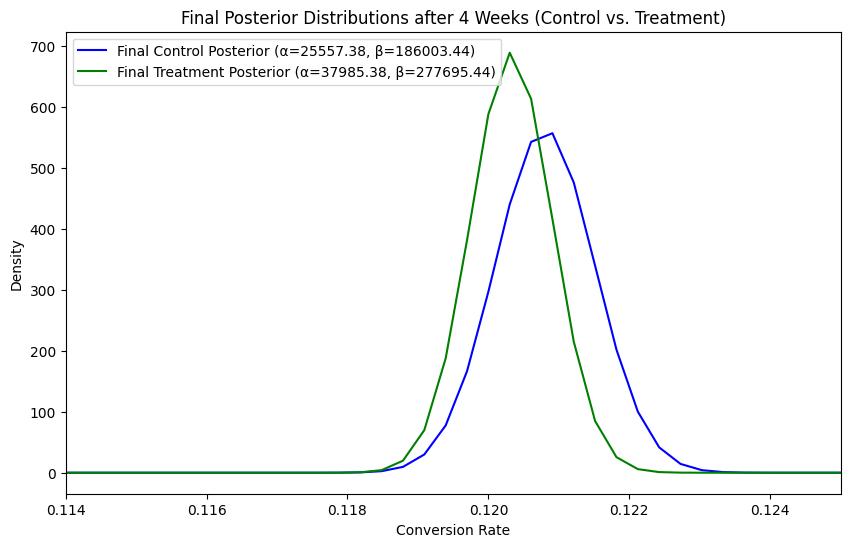

In [47]:
# 최종 Control과 Treatment 그룹별 posterior 분포들 비교
plt.figure(figsize=(10, 6))

# Control 그룹의 최종 posterior distribution 시각화
y_control_final = beta.pdf(x, posterior_control_alpha, posterior_control_beta)
plt.plot(x, y_control_final, label=f'Final Control Posterior (α={posterior_control_alpha:.2f}, β={posterior_control_beta:.2f})', color='blue')

# Treatment 그룹의 최종 posterior distribution 시각화
y_treatment_final = beta.pdf(x, posterior_treatment_alpha, posterior_treatment_beta)
plt.plot(x, y_treatment_final, label=f'Final Treatment Posterior (α={posterior_treatment_alpha:.2f}, β={posterior_treatment_beta:.2f})', color='green')

# 그래프 설정
plt.title('Final Posterior Distributions after 4 Weeks (Control vs. Treatment)')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.xlim(0.114, 0.125)
plt.legend()
plt.show()

In [48]:
# posterior 샘플링 수
n_samples = 10000

# 각 그룹의 posterior 로 부터 랜덤 샘플링
control_posterior_sample = np.random.beta(posterior_control_alpha, posterior_control_beta, n_samples)
treatment_posterior_sample = np.random.beta(posterior_treatment_alpha, posterior_treatment_beta, n_samples)

# Control 및 Treatment 그룹의 posterior 특성 계산
control_mu = control_posterior_sample.mean()
control_var = control_posterior_sample.var()
treatment_mu = treatment_posterior_sample.mean()
treatment_var = treatment_posterior_sample.var()

print(f"Control 그룹 Posterior Distribution: 평균: {control_mu:.6f}, 분산: {control_var:.8f}")
print(f"Treatment 그룹 Posterior Distribution: 평균: {treatment_mu:.6f}, 분산: {treatment_var:.8f}")

Control 그룹 Posterior Distribution: 평균: 0.120797, 분산: 0.00000049
Treatment 그룹 Posterior Distribution: 평균: 0.120331, 분산: 0.00000033


두 그룹의 사후 분포를 보면, Control 그룹과 Treatment 그룹의 전환율 차이는 거의 없습니다. 두 그룹 간의 분포는 상당 부분 겹치고 있으며, 평균 전환율의 차이가 매우 작습니다. 따라서 Treatment 그룹이 Control 그룹보다 전환율을 개선하지 못했을 가능성이 큽니다.

Frequentist 접근법에서는 "A안과 B안의 차이는 통계적으로 유의미하다"와 같은 결론을 도출했지만, Bayesian 접근법을 통해서는 보다 구체적인 통찰을 얻을 수 있습니다. 예를 들어, "B안이 A안에 비해 전환율을 XX% 이상 개선할 확률이 XX%다"와 같은 확률적 해석이 가능합니다. 이제 사후 분포에서 샘플링한 결과를 바탕으로 이러한 의미 있는 확률들을 계산하고, 보다 의미 있는 인사이트를 도출해보겠습니다.

In [49]:
# Treatment 그룹이 Control 그룹보다 우수할 확률 계산
prob_treatment_better = (treatment_posterior_sample > control_posterior_sample).mean()
print(f"Treatment 그룹이 Control 그룹보다 우수할 확률: {prob_treatment_better * 100:.2f}%")

# 전환율 상승 효과(lift)의 백분율 계산
lift_percentage = ((treatment_posterior_sample - control_posterior_sample) / control_posterior_sample) * 100

# 2% 이상의 리프트가 발생할 확률 계산
prob_lift_greater_than_1 = np.mean(lift_percentage > 2) * 100
print(f"2% 이상의 리프트가 발생할 확률: {prob_lift_greater_than_1:.3f}%")

# 전환율 하락(감소) 효과 계산
prob_lift_less_than_0 = np.mean(lift_percentage < 0) * 100
print(f"전환율이 감소할 확률 (0% 이하): {prob_lift_less_than_0:.3f}%")


Treatment 그룹이 Control 그룹보다 우수할 확률: 30.34%
2% 이상의 리프트가 발생할 확률: 0.050%
전환율이 감소할 확률 (0% 이하): 69.660%


 Treatment 그룹이 Control 그룹보다 전환율이 더 높을 가능성은 상대적으로 낮고, 오히려 **전환율이 감소할 확률이 69.66%** 로 매우 높은 상황입니다. 또한, 2% 이상의 리프트가 발생할 확률은 거의 없기 때문에, 현재의 Treatment 전략이 Control 그룹에 비해 성과(전환율)를 개선하는 데 큰 효과가 없음을 시사합니다.

### MCMC (Markov Chain Monte Carlo) 기반 사후 분포 추정

이번 분석에서는 PyMC 라이브러리를 활용하여 Control 그룹과 Treatment 그룹의 사후 분포를 MCMC를 통해 추정할 것입니다.

PyMC는 베이지안 통계 모델링을 위한 도구로, MCMC 기법을 사용해 복잡한 확률 모델의 사후 분포를 추정할 수 있습니다. 이번 분석에서는 베타 분포를 사전 분포로 설정하고, 각 그룹의 전환 데이터를 베르누이 분포로 모델링하여 PyMC의 MCMC 샘플링을 통해 사후 분포를 계산할 예정입니다. 이를 통해 두 그룹 간의 전환율 차이를 확률적으로 비교하고, 불확실성을 정량화 하겠습니다.

In [50]:
# 베이지안 분석 프레임워크 내에 likelihood 함수를 만들기 위해서 2, 3, 4주차의 Control 그룹과 Treatment 그룹 데이터를 필터링합니다.
likelihood_control_data = df[(df['week'].isin([2, 3, 4])) & (df['group'] == 'control')]
likelihood_treatment_data = df[(df['week'].isin([2, 3, 4])) & (df['group'] == 'treatment')]

In [51]:
# Control 그룹에 대한 posterior 샘플링
with pm.Model() as control_model:
    # Control 그룹에 대한 prior로 베타 (beta) 분포 사용
    control_conversion_rate = pm.Beta('control_conversion_rate', alpha=prior_control_alpha, beta=prior_control_beta)
    
    # Likelihood 함수로 벨눌리 (bernoulli) 분포 사용 (베타 분포는 벨눌리 분포의 conjugate prior)
    control_conversion_obs = pm.Bernoulli('control_conversion_obs', p=control_conversion_rate, observed=likelihood_control_data['converted'])
    
    # posterior 분포에서 샘플링
    control_trace = pm.sample(200, tune=100, target_accept=0.95)
    
    # Control 그룹의 MCMC trace 저장
    # az.to_netcdf(control_trace, "control_mcmc_trace.nc")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_conversion_rate]


Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 649 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [52]:
# Treatment 그룹에 대한 posterior 샘플링
with pm.Model() as treatment_model:
    # Treatment 그룹에 대한 prior로 베타 (beta) 분포 사용
    treatment_conversion_rate = pm.Beta('treatment_conversion_rate', alpha=prior_control_alpha, beta=prior_control_beta)
    
    # Likelihood 함수
    treatment_conversion_obs = pm.Bernoulli('treatment_conversion_obs', p=treatment_conversion_rate, observed=likelihood_treatment_data['converted'])
    
    # posterior 분포에서 샘플링
    treatment_trace = pm.sample(200, tune=100, target_accept=0.95)
    
    # Treatment 그룹의 MCMC trace 저장
    # az.to_netcdf(treatment_trace, "treatment_mcmc_trace.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treatment_conversion_rate]


Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 527 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [50]:
# Trace 로드
control_trace = az.from_netcdf("control_mcmc_trace.nc")
treatment_trace = az.from_netcdf("treatment_mcmc_trace.nc")

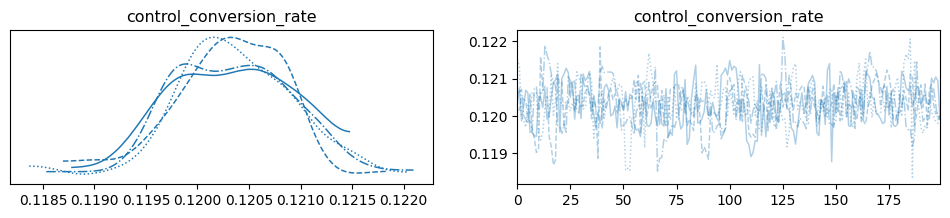

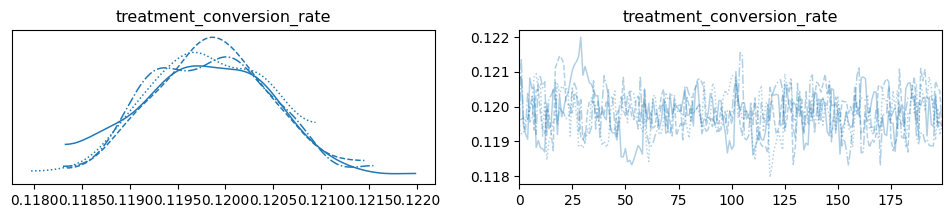

In [51]:
# Trace plot으로 MCMC 샘플링 결과 시각화
az.plot_trace(control_trace)
plt.show()

az.plot_trace(treatment_trace)
plt.show()

이 그래프는 MCMC 샘플링 결과를 시각화한 것입니다. 두 그룹 모두 전환율의 사후 분포가 비슷한 범위에 걸쳐 있으며, 분포가 상당히 중첩되어 있어 전환율 차이가 크지 않음을 시사합니다. 또한, MCMC 샘플링 과정에서 두 그룹 모두 안정적으로 수렴된 것을 확인할 수 있으며, 추정된 전환율 값들이 일정한 범위에 집중되어 있습니다. 따라서, 두 그룹 간의 실질적인 전환율 차이는 없거나 매우 작을 가능성이 높으며, Treatment 그룹이 Control 그룹보다 유의미한 개선을 보였다고 결론내리기 어렵습니다.

Control 그룹의 95% HDI: <xarray.Dataset> Size: 64B
Dimensions:                  (hdi: 2)
Coordinates:
  * hdi                      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    control_conversion_rate  (hdi) float64 16B 0.1193 0.1215
Treatment 그룹의 95% HDI: <xarray.Dataset> Size: 64B
Dimensions:                    (hdi: 2)
Coordinates:
  * hdi                        (hdi) <U6 48B 'lower' 'higher'
Data variables:
    treatment_conversion_rate  (hdi) float64 16B 0.1187 0.1209


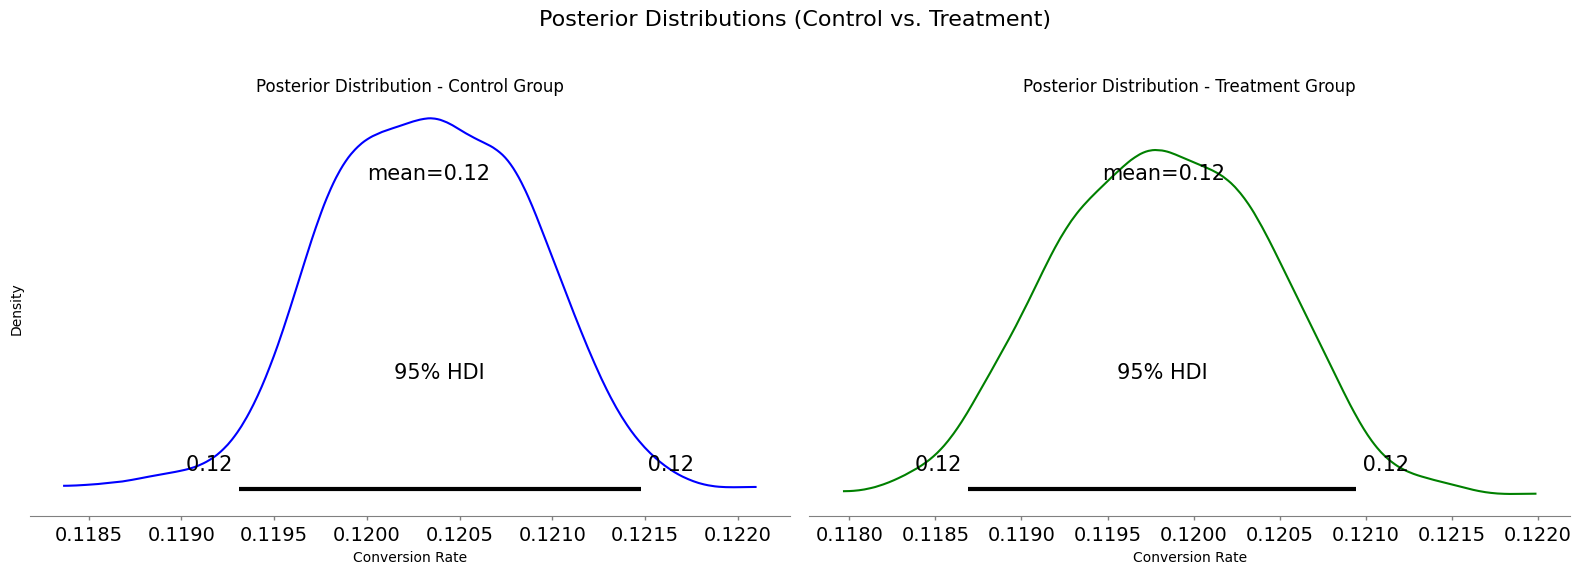

In [8]:
# HDI 계산
hdi_control = az.hdi(control_trace.posterior['control_conversion_rate'], hdi_prob=0.95)
hdi_treatment = az.hdi(treatment_trace.posterior['treatment_conversion_rate'], hdi_prob=0.95)

print(f"Control 그룹의 95% HDI: {hdi_control}")
print(f"Treatment 그룹의 95% HDI: {hdi_treatment}")


# 각 그룹의 posterior 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Control 그룹 posterior 분포
az.plot_posterior(control_trace, var_names=['control_conversion_rate'], hdi_prob=0.95, ax=axes[0], color='blue')
axes[0].set_title('Posterior Distribution - Control Group')
axes[0].set_xlabel('Conversion Rate')
axes[0].set_ylabel('Density')

# Treatment 그룹 posterior 분포
az.plot_posterior(treatment_trace, var_names=['treatment_conversion_rate'], hdi_prob=0.95, ax=axes[1], color='green')
axes[1].set_title('Posterior Distribution - Treatment Group')
axes[1].set_xlabel('Conversion Rate')

# 타이틀
fig.suptitle('Posterior Distributions (Control vs. Treatment)', fontsize=16)

# 레이아웃
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Control 그룹의 95% HDI(Highest Density Interval)는 0.1193에서 0.1215 사이이며, Treatment 그룹의 95% HDI는 0.1187에서 0.1209 사이입니다. HDI는 사후 분포에서 가장 가능성 높은 값들이 포함된 구간을 나타내며, 이 구간 내에 실제 전환율이 존재할 확률이 95%임을 의미합니다.

두 그룹의 HDI 구간이 상당 부분 겹치고 있으며, 특히 평균 전환율에서 큰 차이를 보이지 않습니다. 이는 두 그룹 간에 통계적으로 유의미한 전환율 차이가 없을 가능성이 높음을 시사합니다. Treatment 그룹의 전환율이 Control 그룹보다 약간 낮을 가능성도 있지만, 그 차이는 매우 미미하여, 실질적인 개선 효과가 없다고 결론지을 수 있습니다.

In [9]:
# 각 그룹의 posterior 분포에서 샘플링
control_posterior_samples = control_trace.posterior['control_conversion_rate'].values.flatten()
treatment_posterior_samples = treatment_trace.posterior['treatment_conversion_rate'].values.flatten()

In [10]:
# Control 및 Treatment 그룹 posterior 분포의 특성
control_mu = control_posterior_samples.mean()
control_var = control_posterior_samples.var()
treatment_mu = treatment_posterior_samples.mean()
treatment_var = treatment_posterior_samples.var()

print(f"Control 그룹 Posterior 분포: 평균: {control_mu:.6f}, 분산: {control_var:.8f}")
print(f"Treatment 그룹 Posterior 분포: 평균: {treatment_mu:.6f}, 분산: {treatment_var:.8f}")

Control 그룹 Posterior 분포: 평균: 0.120331, 분산: 0.00000033
Treatment 그룹 Posterior 분포: 평균: 0.119824, 분산: 0.00000039


In [15]:
# Treatment가 Control보다 우수할 확률 계산
prob_treatment_better = (treatment_posterior_samples > control_posterior_samples).mean()
print(f"Treatment가 Control보다 우수할 확률: {prob_treatment_better * 100:.2f}%")

# 전환율 상승 효과(lift) 백분율 계산
lift_percentage = ((treatment_posterior_samples - control_posterior_samples) / control_posterior_samples) * 100

# 2% 이상의 lift 보일 확률
prob_lift_greater_than_2 = np.mean(lift_percentage > 2) * 100
print(f"2% 이상 리프트 발생 확률: {prob_lift_greater_than_2:.4f}%")

# 전환율 하락(감소) 효과 계산
prob_lift_less_than_0 = np.mean(lift_percentage < 0) * 100
print(f"전환율이 감소할 확률 (0% 이하): {prob_lift_less_than_0:.3f}%")

Treatment가 Control보다 우수할 확률: 27.12%
2% 이상 리프트 발생 확률: 0.2500%
전환율이 감소할 확률 (0% 이하): 72.875%


Treatment 그룹이 Control 그룹보다 전환율이 더 높을 확률은 27.12%로, 상당히 낮은 편에 속합니다. 반면, 전환율이 감소할 확률은 72.875%로 매우 높아, Treatment 그룹이 오히려 성과를 저하할 가능성이 큽니다. 또한, 2% 이상의 리프트가 발생할 확률은 0.25%에 불과해, 실질적인 개선 효과를 기대하기 어려운 상황입니다. 이를 종합해 볼 때, 현재의 Treatment 전략이 Control 그룹에 비해 전환율을 개선하는 데 효과적이지 않을 것임을 보여줍니다.

## Actionable Insights

이 분석 결과를 바탕으로 얻을 수 있는 actionable insights는 다음과 같습니다:

- MCMC를 사용한 Bayesian 분석 결과, Treatment 그룹이 Control 그룹보다 전환율이 더 높을 확률은 27.12%에 불과하며, 2% 이상의 리프트가 발생할 확률은 0.25%로 매우 낮습니다. 오히려 Treatment 그룹의 전환율이 감소할 확률이 72.87%로 매우 높습니다. 따라서, 현재의 Treatment 전략은 성과 개선에 큰 기여를 하지 못하고 있으며, 개선이 필요합니다.


- 분석 결과, Treatment 그룹의 성과가 기대에 미치지 못하고 있기 때문에, 전환율을 높이기 위한 새로운 전략을 고려해야 합니다. 새로운 Treatment 전략을 도입한 후 추가적인 A/B 테스트를 통해 성과를 평가하는 것이 필요합니다.


- 현재 Treatment 전략은 Control 그룹 대비 성과가 부족하므로, 사용자 경험(UX) 개선, 더 나은 콘텐츠 배치, 혹은 전환 과정을 단순화하는 등의 전략 수정이 요구됩니다. 전환율을 높이기 위해 UX/UI 디자인을 재검토하고 개선 방안을 마련하는 것을 생각해 봐야합니다.

- 세분화된 사용자 군집 분석이나 실험 설계 변경을 통해, 특정 사용자 그룹에 맞춘 맞춤형 전략을 테스트하는 것도 고려할 수 있겠습니다.